# Exploration vs Exploitation

In this notebook we will look at the exploration vs exploitation dilemma. We will consider a simpler environment known as **Mulit Arm Bandit**.

We will implement three variations of exploration strategy and compare their relative performance. 

Our Bandit has $K$ actions. Each action has a probability of success $\theta_k$ which is known to us. When you pull the kth arm, it produces a reward $r$ of 1 with probability $\theta_k$ and reward $r$ of 0 with probability $1-\theta_k$.

Let the optimal action be defined as the one which has maximum probability of success i.e. $\theta_k$.

$\theta^* = \max_k\{\theta_k\}$

The regret at a time step t is defined as $\theta^* - r_t$

The total regret for a fixed time horizon T is defined as:
$$\rho = T . \theta^* - \sum_{t=1}^T r_t$$

We will use three different exploration strategies and see how total regret grows as a function of T.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Bandit Environment
`Bandit` implements the environment. We are using non contextual multi arm bandit. In other words the environment has no state, we take an action and observe the reward and the episode terminates. In next time step, we choose another action as per our exploration strategy to get another reward followed by episode termination. This cycle goes on for T time steps. 

In [2]:
class Bandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)
        self.n_actions = n_actions

    def pull(self, action):
        if np.random.random() > self._probs[action]:
            return 0.0
        return 1.0

    def optimal_reward(self):
        return np.max(self._probs)

### Random Sampling Agent

In this the agent randomly chooses an action from available actions and records the regret. There is no exploitation. Only random exploration. We know that it will behave very badly.

In [3]:
class RandomAgent:
    def __init__(self, n_actions=5):
        self.success_cnt = np.zeros(n_actions)
        self.failure_cnt = np.zeros(n_actions)
        self.total_pulls = 0
        self.n_actions = n_actions
        
    def reset(self):
        self.success_cnt = np.zeros(n_actions)
        self.failure_cnt = np.zeros(n_actions)
        self.total_pulls = 0        
        
    def get_action(self):
        return np.random.randint(0, self.n_actions)
    
    def update(self, action, reward):
        self.total_pulls += 1
        self.success_cnt[action] += reward
        self.failure_cnt[action] += 1 - reward

### Epsilon Greedy Sampling Agent

This is similar to the $\epsilon$-greedy strategy we have seen in all previous chapters. The agent tries different actions and forms an estimate $\{\hat{\theta}_k\}$ of the unknown actual success probabilities $\{\theta_k\}$ of `Bandit` environment. It takes the action with  $\hat{\theta}^* = \max_k\{\hat{\theta}_k\}$ with $1-\epsilon$ probability(exploit) and takes a random action with probability $\epsilon$ (explore).

In [4]:
class EGreedyAgent(RandomAgent):
    def __init__(self, n_actions=5, epsilon=0.01):
        super().__init__(n_actions)
        self.epsilon = epsilon
    
    def get_action(self):
        estimates = self.success_cnt / (self.success_cnt+self.failure_cnt+1e-12)
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        else:
            return np.argmax(estimates)

### UCB1 Sampling Agent
The agent tries different actions and records the number of successes ($\alpha_k$) and failures ($\beta_k$). 

It calculates the estimates of success probabilities:
$$exploit = \hat{\theta}_k = \frac{\alpha_k}{\alpha_k + \beta_k}$$ 

It also calculates the exploration which favors the less visited actions more:
$$explore = \sqrt{\frac{2.\log{t}}{\alpha_k + \beta_k}} $$

The agent then picks the action with maximum of explore + exploit score: 
$$score = \frac{\alpha_k}{\alpha_k + \beta_k} + \eta\sqrt{\frac{2.\log{t}}{\alpha_k + \beta_k}} $$ 
where $\eta$ controls the relative importance of explore vs exploit. We will use $\eta=1$ in our code.

In [5]:
class UCBAgent(RandomAgent):
    def get_action(self):
        exploit = self.success_cnt / (self.success_cnt+self.failure_cnt+1e-12)
        explore = np.sqrt(2*np.log(np.maximum(self.total_pulls,1))/(self.success_cnt+self.failure_cnt+1e-12))
        estimates =  exploit + explore
        return np.argmax(estimates)        

### Thompson Sampling Agent

This is based on Bayesian Approach. We start with an agent which has uniform probability (prior) which is reflected with a prior beta distribution of $Beta(\alpha=1, \beta=1)$. The agent then samples the actions using this distribution. And then it picks the action with maximum $\hat{\theta}_k$

As the success and failure counts are updated in each step, the agent updates it belief of the $\hat{\theta}_k$:

$\hat{\theta}_k \sim Beta(\alpha=\alpha_k+1, \beta=\beta_k+1)$ 

It uses the updated $Beta$ distribution to sample and pick the action with maximum $\hat{\theta}_k$. And the cycle goes on

It is basically picking up actions based on the samples of the belief of which action has the what chance of being best.

In [6]:
class ThompsonAgent(RandomAgent):
    def get_action(self):
        estimates = np.random.beta(self.success_cnt+1, self.failure_cnt+1)
        return np.argmax(estimates)

### Playout
`get_regret` calculates the total regret for a given agent and an environment with fixed $\theta_k$'s

In [7]:
def get_regret(env, agent, n_steps=10000, n_trials=10):
    score = np.zeros(n_steps)
    optimal_r = env.optimal_reward()

    for trial in range(n_trials):
        agent.reset()
        for t in range(n_steps):
            action = agent.get_action()
            reward = env.pull(action)
            agent.update(action, reward)
            score[t] += optimal_r - reward
    score = score / n_trials
    score = np.cumsum(score)
    return score

### Plot
We plot the total regret curve for all the three exploration strategies

In [8]:
def plot_regret(agents, scores):
    for k,v in agents.items():
        plt.plot(scores[k])
    plt.legend([k for k,v in agents.items()])
    plt.ylabel("regret")
    plt.xlabel("steps")
    plt.show()

### Everything put together

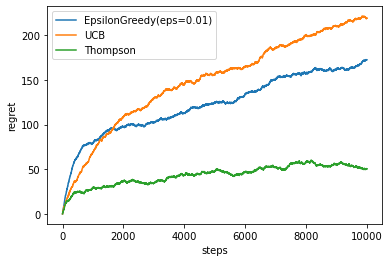

In [9]:
n_actions = 5
epsilon = 0.01

agents = {
    #"Random" : RandomAgent(n_actions), 
    "EpsilonGreedy(eps=0.01)" : EGreedyAgent(n_actions, epsilon),
    "UCB": UCBAgent(n_actions),
    "Thompson": ThompsonAgent(n_actions) }

env = Bandit(n_actions)
scores = {}

for name, agent in agents.items():
    score = get_regret(env, agent)
    scores[name] = score

plot_regret(agents, scores)